In [10]:
! pip install pandas
! pip install numpy
! pip install matplotlib
! pip install seaborn
! pip install sklearn
! pip install xgboost
! pip install catboost
! pip install imbalanced-learn


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replac

In [11]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, f_classif, RFECV
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    average_precision_score, confusion_matrix, matthews_corrcoef
)
import time


In [13]:
# Load Dataset
df = pd.read_csv("/Users/ajanthanjoseph/Documents/GitHub/CIND820/diabetes_012_health_indicators_BRFSS2015.csv")

In [14]:
# Feature Engineering

df["BMI_Age"] = df["BMI"] * df["Age"]
df["HighBP_HighChol"] = df["HighBP"] * df["HighChol"]
df["PhysActivity_BMI"] = df["PhysActivity"] * df["BMI"]

In [15]:
# Feature Selection
# Display top features by Chi-Square and ANOVA
X = df.drop(columns=["Diabetes_012"])
y = df["Diabetes_012"]

chi2_selector = SelectKBest(score_func=chi2, k='all')
chi2_selector.fit(X, y)
chi2_scores = chi2_selector.scores_

anova_selector = SelectKBest(score_func=f_classif, k='all')
anova_selector.fit(X, y)
anova_scores = anova_selector.scores_

feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Chi2 Score': chi2_scores,
    'ANOVA F Score': anova_scores
}).sort_values(by='ANOVA F Score', ascending=False)

# Print all features with scores before dropping
print("Top Features by Chi-Square:")
print(feature_scores.sort_values(by='Chi2 Score', ascending=False))

print("Top Features by ANOVA F Score:")
print(feature_scores.sort_values(by='ANOVA F Score', ascending=False))

X_reduced = X.copy()  # No feature dropping here; RFECV will handle selection

Top Features by Chi-Square:
                 Feature     Chi2 Score  ANOVA F Score
21               BMI_Age  922213.400451   11905.944685
15              PhysHlth  141598.783225    4078.699854
14              MentHlth   24607.463010     717.117372
3                    BMI   19775.252090    6768.361067
22       HighBP_HighChol   14392.694424   10453.965178
0                 HighBP   10731.721009   10149.140418
16              DiffWalk   10627.556856    6727.221134
13               GenHlth   10595.234173   12832.660123
18                   Age   10225.159975    4560.441068
6   HeartDiseaseorAttack    7468.339377    4260.879233
1               HighChol    6483.776499    5890.843228
20                Income    5380.434934    3913.752954
23      PhysActivity_BMI    3981.998963     244.921534
5                 Stroke    2798.417025    1475.321639
7           PhysActivity     922.529401    1923.358158
19             Education     849.169260    2245.725730
10     HvyAlcoholConsump     802.5385

In [16]:
# Standardize numerical features
scaler = StandardScaler()
numerical_features = ["BMI", "Age", "BMI_Age", "PhysActivity_BMI"]
existing_numerical_features = [col for col in numerical_features if col in X_reduced.columns]
X_reduced[existing_numerical_features] = scaler.fit_transform(X_reduced[existing_numerical_features])

In [17]:
# === Selection of Features using RFECV ===
rfecv_selector = RFECV(estimator=LogisticRegression(max_iter=1000), step=1, cv=5, scoring='accuracy')
X_rfecv = rfecv_selector.fit_transform(X_reduced, y)
print("Selected features by RFECV:", X_reduced.columns[rfecv_selector.support_].tolist())

Selected features by RFECV: ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'HeartDiseaseorAttack', 'HvyAlcoholConsump', 'NoDocbcCost', 'GenHlth', 'Age', 'BMI_Age']


In [18]:
# Model Evaluation
results = []
confusion_matrices = {
    "Unbalanced": {},
    "SMOTE": {},
    "Tuned": {}
}

def evaluate_model(name, model, X_train, y_train, X_test, y_test, stage):
    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices[stage][name] = cm

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name} ({stage})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    return {
        'Model': name + f" ({stage})",
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1 Score': f1_score(y_test, y_pred, average='weighted'),
        'PR-AUC': average_precision_score(y_test, y_proba, average='weighted'),
        'MCC': matthews_corrcoef(y_test, y_pred),
        'Train Time (s)': round(train_time, 2)
    }

In [19]:
# Define models to be evaluated
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}

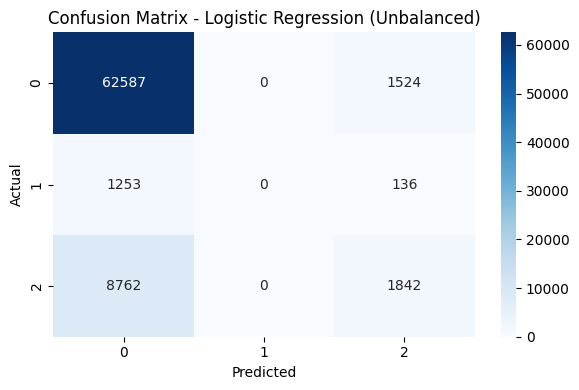

/Users/ajanthanjoseph/Documents/GitHub/CIND820/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


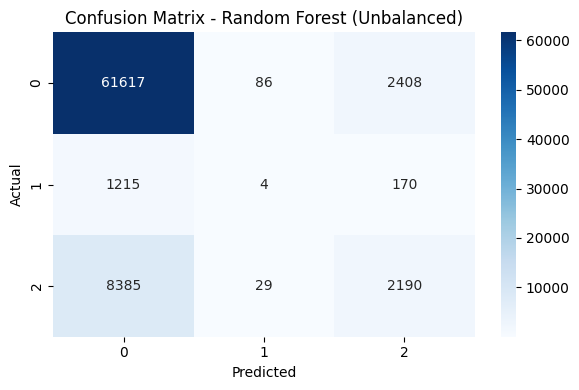

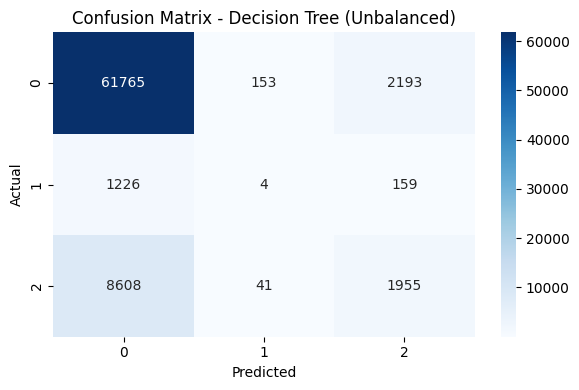

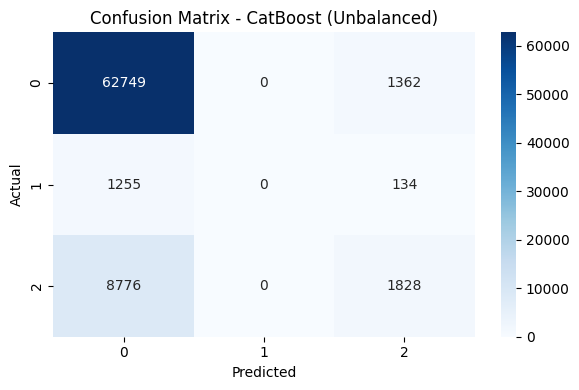

/Users/ajanthanjoseph/Documents/GitHub/CIND820/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


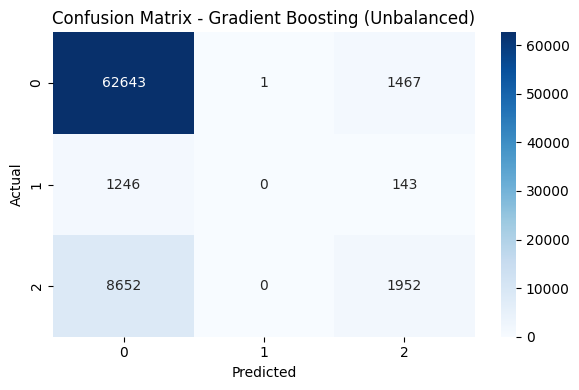

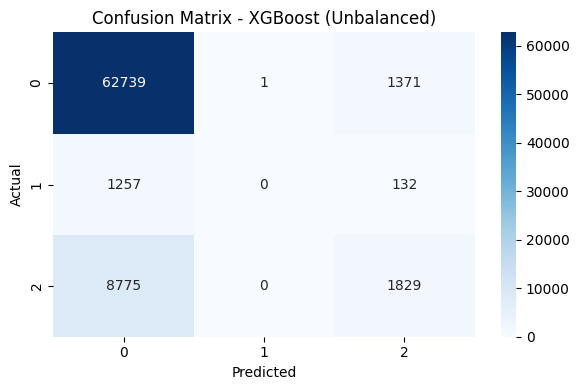


=== Evaluation Results: Unbalanced Data (RFECV-Selected Features) ===


,Model,Accuracy,Precision,Recall,F1 Score,PR-AUC,MCC,Train Time (s)
0,Logistic Regression (Unbalanced),0.846592,0.799496,0.846592,0.807700,0.863884,0.237010,9.72
1,Random Forest (Unbalanced),0.838471,0.793468,0.838471,0.806926,0.843971,0.229361,40.94
2,Decision Tree (Unbalanced),0.837328,0.790324,0.837328,0.803435,0.821397,0.211974,1.25
3,CatBoost (Unbalanced),0.848536,0.802933,0.848536,0.808876,0.867354,0.244973,107.64
4,Gradient Boosting (Unbalanced),0.848773,0.803825,0.848773,0.810745,0.868518,0.252742,139.39
5,XGBoost (Unbalanced),0.848418,0.802764,0.848418,0.808803,0.866651,0.244433,16.57
6,Logistic Regression (Unbalanced),0.846592,0.799496,0.846592,0.807700,0.863884,0.237010,6.79
7,Random Forest (Unbalanced),0.838471,0.793468,0.838471,0.806926,0.843971,0.229361,40.59
8,Decision Tree (Unbalanced),0.837328,0.790324,0.837328,0.803435,0.821397,0.211974,1.43
9,CatBoost (Unbalanced),0.848536,0.802933,0.848536,0.808876,0.867354,0.244973,160.92


In [25]:
# === Model and Evaluation using RFECV-Selected Features (Unbalanced, Balanced with SMOTE, and Tuned) ===
X_train_rfecv, X_test_rfecv, y_train_rfecv, y_test_rfecv = train_test_split(
    X_rfecv, y, test_size=0.3, stratify=y, random_state=42
)

for name, model in models.items():
    results.append(evaluate_model(name, model, X_train_rfecv, y_train_rfecv, X_test_rfecv, y_test_rfecv, "Unbalanced"))

print("\n=== Evaluation Results: Unbalanced Data (RFECV-Selected Features) ===")
rfecv_results = [r for r in results if "(Unbalanced)" in r['Model']]
rfecv_df = pd.DataFrame(rfecv_results)
display(rfecv_df)


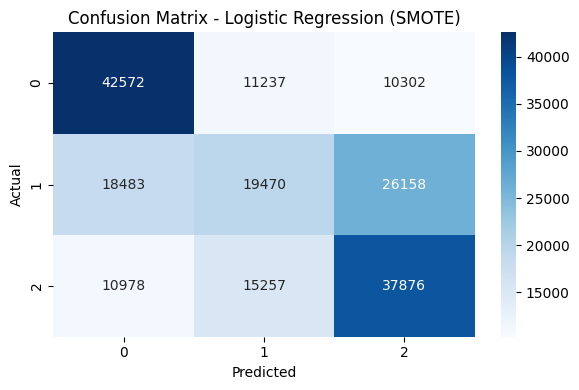

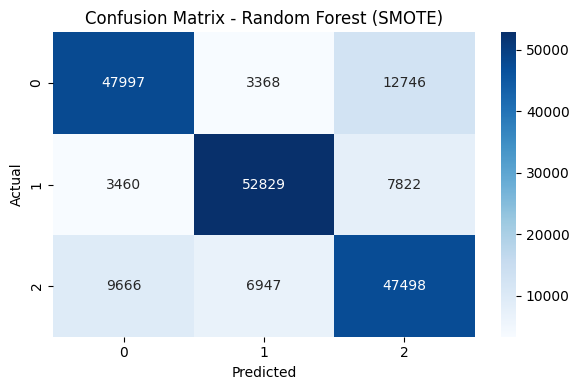

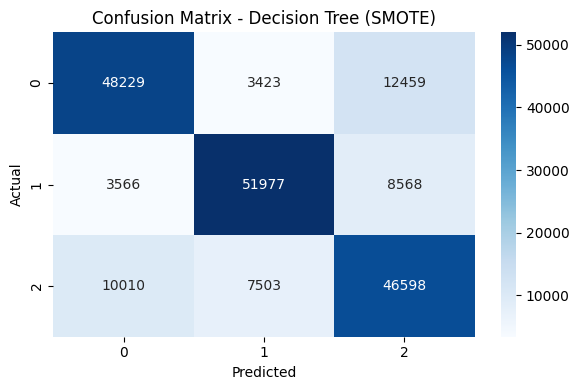

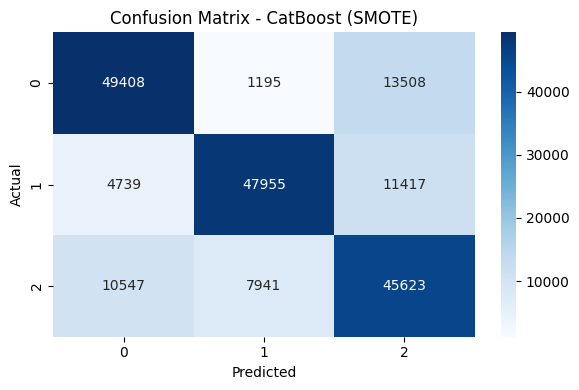

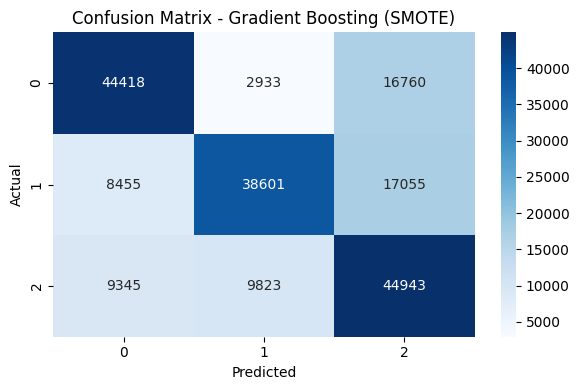

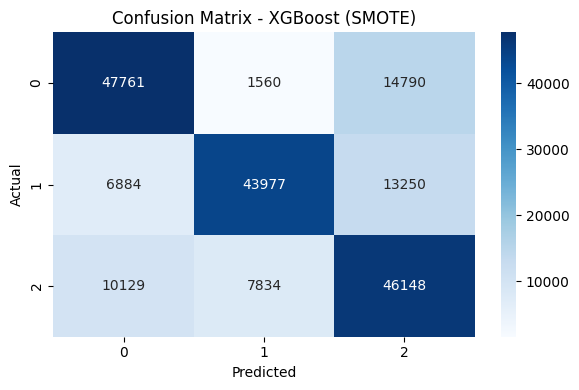


=== Evaluation Results: SMOTE-Balanced Data (RFECV-Selected Features) ===


,Model,Accuracy,Precision,Recall,F1 Score,PR-AUC,MCC,Train Time (s)
0,Logistic Regression (SMOTE),0.519505,0.508041,0.519505,0.508770,0.545452,0.282113,27.42
1,Random Forest (SMOTE),0.771183,0.773240,0.771183,0.771835,0.857006,0.657115,219.57
2,Decision Tree (SMOTE),0.763280,0.765237,0.763280,0.763980,0.802765,0.645171,6.14
3,CatBoost (SMOTE),0.743429,0.750129,0.743429,0.745369,0.835431,0.616283,306.42
4,Gradient Boosting (SMOTE),0.665315,0.678726,0.665315,0.666987,0.736419,0.501862,491.28
5,XGBoost (SMOTE),0.716913,0.727792,0.716913,0.719055,0.804616,0.577921,24.10
6,Logistic Regression (SMOTE),0.519505,0.508041,0.519505,0.508770,0.545452,0.282113,23.68
7,Random Forest (SMOTE),0.771183,0.773240,0.771183,0.771835,0.857006,0.657115,215.51
8,Decision Tree (SMOTE),0.763280,0.765237,0.763280,0.763980,0.802765,0.645171,5.95
9,CatBoost (SMOTE),0.743429,0.750129,0.743429,0.745369,0.835431,0.616283,334.54


In [26]:
# === Model and Evaluation using RFECV-Selected Features - SMOTE-Balanced Data ===
smote = SMOTE(random_state=42)
X_smote_rfecv, y_smote_rfecv = smote.fit_resample(X_rfecv, y)
X_train_smote_rfecv, X_test_smote_rfecv, y_train_smote_rfecv, y_test_smote_rfecv = train_test_split(
    X_smote_rfecv, y_smote_rfecv, test_size=0.3, stratify=y_smote_rfecv, random_state=42
)

for name, model in models.items():
    results.append(evaluate_model(name, model, X_train_smote_rfecv, y_train_smote_rfecv, X_test_smote_rfecv, y_test_smote_rfecv, "SMOTE"))


print("\n=== Evaluation Results: SMOTE-Balanced Data (RFECV-Selected Features) ===")
smote_results = [r for r in results if "(SMOTE)" in r['Model']]
smote_df = pd.DataFrame(smote_results)
display(smote_df)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


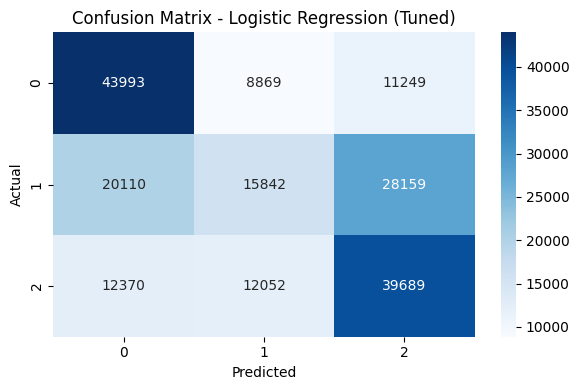

Fitting 2 folds for each of 2 candidates, totalling 4 fits


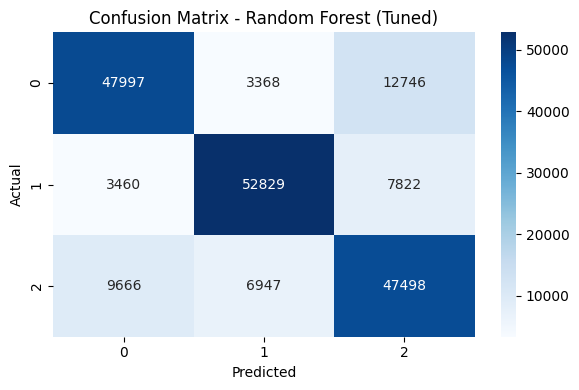

Fitting 2 folds for each of 2 candidates, totalling 4 fits


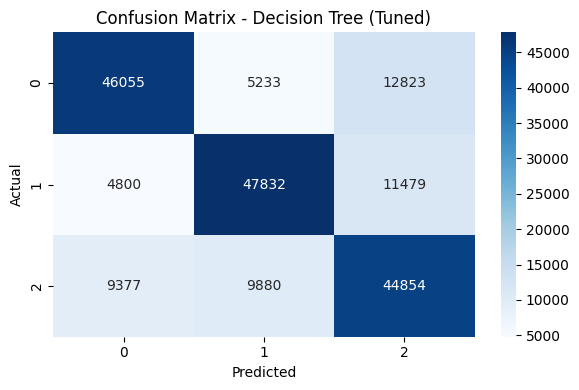

/Users/ajanthanjoseph/Documents/GitHub/CIND820/venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=2. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


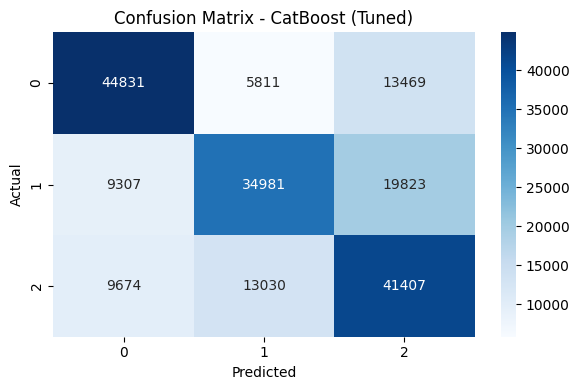

/Users/ajanthanjoseph/Documents/GitHub/CIND820/venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=2. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits


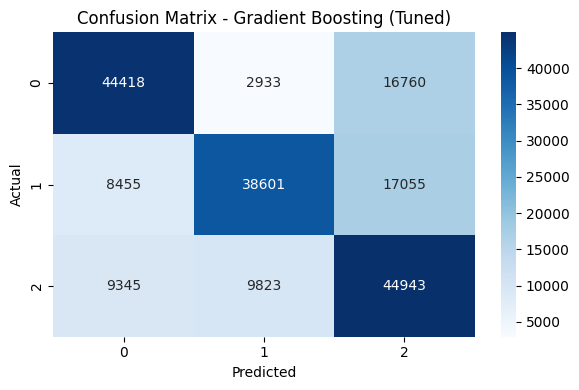

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/Users/ajanthanjoseph/Documents/GitHub/CIND820/venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=2. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


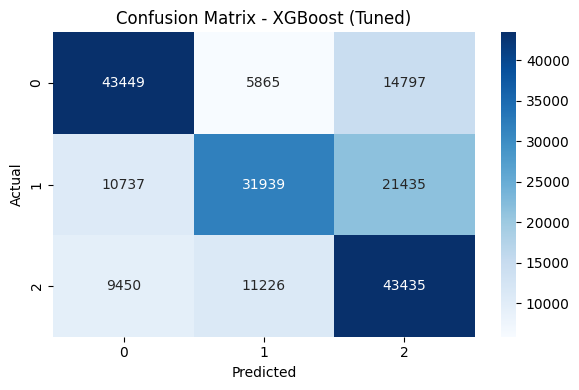


=== Evaluation Results: Tuned Models (SMOTE + RFECV Features) ===


,Model,Accuracy,Precision,Recall,F1 Score,PR-AUC,MCC,Train Time (s)
0,Logistic Regression (Tuned),0.517337,0.502472,0.517337,0.497909,0.541833,0.282540,11.48
1,Logistic Regression (Tuned),0.517337,0.502472,0.517337,0.497909,0.541833,0.282540,12.29
2,Random Forest (Tuned),0.773601,0.775364,0.773601,0.774116,0.861746,0.660730,186.76
3,Decision Tree (Tuned),0.762085,0.764189,0.762085,0.762822,0.804410,0.643409,7.03
4,CatBoost (Tuned),0.704138,0.716730,0.704138,0.706641,0.777651,0.559133,55.89
5,Logistic Regression (Tuned),0.517457,0.502658,0.517457,0.498080,0.541747,0.282710,16.99
6,Random Forest (Tuned),0.771183,0.773240,0.771183,0.771835,0.857006,0.657115,205.04
7,Decision Tree (Tuned),0.721358,0.724373,0.721358,0.722282,0.789808,0.582532,4.14
8,CatBoost (Tuned),0.630256,0.635602,0.630256,0.630247,0.703074,0.447366,41.85
9,Gradient Boosting (Tuned),0.665315,0.678726,0.665315,0.666987,0.736419,0.501862,507.65


In [28]:
# === Model and Evaluation using RFECV-Selected Features - Hyperparameter-Tuned Data (Faster Version) ===

# Optimize: smaller search space and fewer iterations
param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1], 'penalty': ['l2'], 'solver': ['liblinear']
    },
    'Random Forest': {
        'n_estimators': [100], 'max_depth': [10, None], 'min_samples_split': [2]
    },
    'Decision Tree': {
        'max_depth': [10, 20], 'min_samples_split': [2], 'min_samples_leaf': [1]
    },
    'CatBoost': {
        'iterations': [100], 'depth': [4], 'learning_rate': [0.1]
    },
    'Gradient Boosting': {
        'n_estimators': [100], 'learning_rate': [0.1], 'max_depth': [3]
    },
    'XGBoost': {
        'n_estimators': [100], 'max_depth': [3], 'learning_rate': [0.1]
    },
}

# Use n_iter=2 (instead of 5) and n_jobs=-1 to parallelize
for name, model in models.items():
    search = RandomizedSearchCV(
        model,
        param_distributions=param_grids[name],
        n_iter=2,
        cv=2,
        n_jobs=-1,  # Parallel processing
        random_state=42,
        verbose=1
    )
    search.fit(X_train_smote_rfecv, y_train_smote_rfecv)
    best_model = search.best_estimator_
    results.append(evaluate_model(
        name, best_model,
        X_train_smote_rfecv, y_train_smote_rfecv,
        X_test_smote_rfecv, y_test_smote_rfecv,
        "Tuned"
    ))

# Display Results
print("\n=== Evaluation Results: Tuned Models (SMOTE + RFECV Features) ===")
tuned_results = [r for r in results if "(Tuned)" in r['Model']]
tuned_df = pd.DataFrame(tuned_results)
display(tuned_df)


⏳ Tuning Logistic Regression...
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Users/ajanthanjoseph/Documents/GitHub/CIND820/venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=4. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


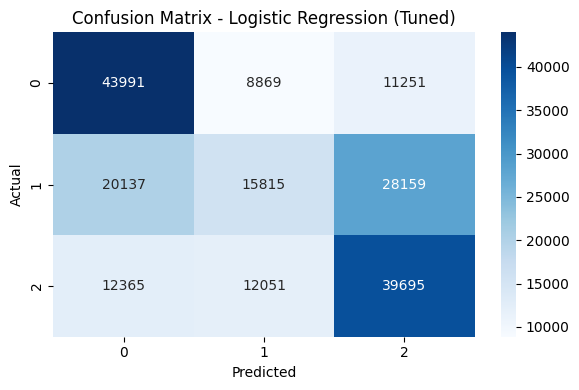

⏳ Tuning Random Forest...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


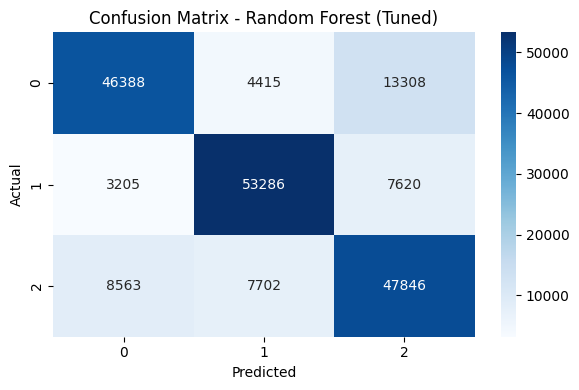

⏳ Tuning Decision Tree...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


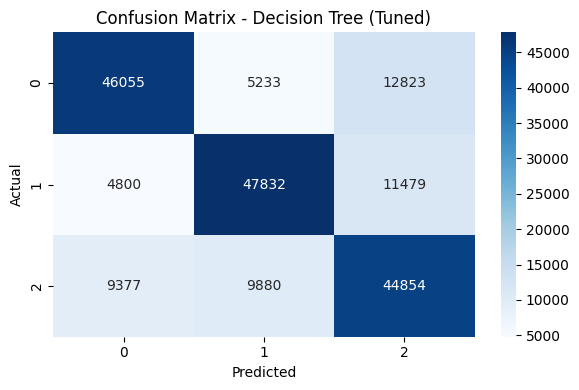

⏳ Tuning CatBoost...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


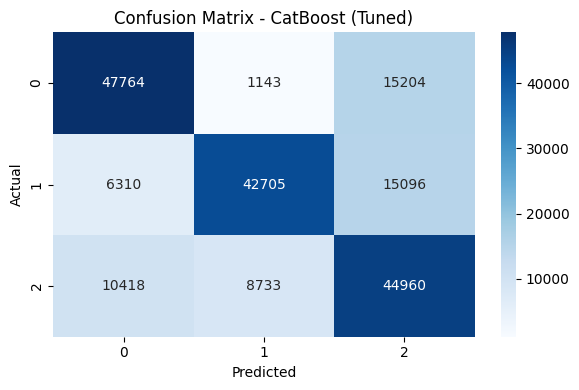

⏳ Tuning Gradient Boosting...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


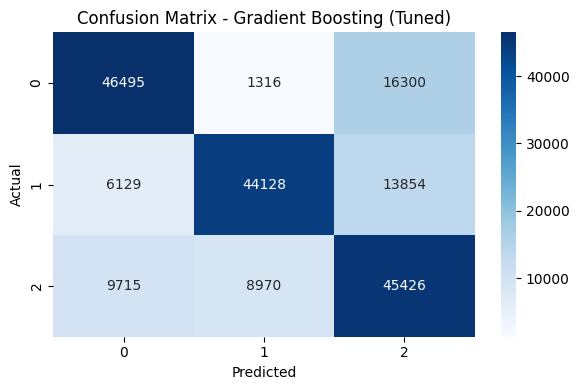

⏳ Tuning XGBoost...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


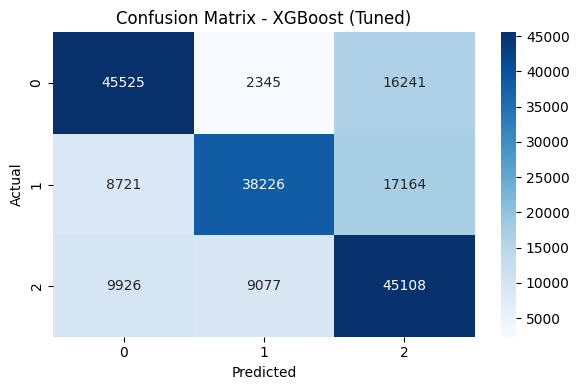


=== Evaluation Results: Tuned Models (SMOTE + RFECV Features) ===


,Model,Accuracy,Precision,Recall,F1 Score,PR-AUC,MCC,Train Time (s)
1,Random Forest (Tuned),0.767003,0.769360,0.767003,0.767257,0.852112,0.651282,269.70
2,Decision Tree (Tuned),0.721358,0.724373,0.721358,0.722282,0.789808,0.582532,4.16
4,Gradient Boosting (Tuned),0.707362,0.719280,0.707362,0.710129,0.780812,0.563662,1149.58
3,CatBoost (Tuned),0.704138,0.716730,0.704138,0.706641,0.777651,0.559133,57.10
5,XGBoost (Tuned),0.669979,0.684630,0.669979,0.671452,0.740710,0.509288,52.84
0,Logistic Regression (Tuned),0.517337,0.502472,0.517337,0.497909,0.541833,0.282540,14.24


In [29]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split

# Use 50% of training data for tuning to speed up search
X_tune, _, y_tune, _ = train_test_split(X_train_smote_rfecv, y_train_smote_rfecv, test_size=0.5, random_state=42)

# Slightly expanded but still efficient search space
param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['liblinear']
    },
    'Random Forest': {
        'n_estimators': [100, 150],
        'max_depth': [10, 20],
        'min_samples_split': [2, 5]
    },
    'Decision Tree': {
        'max_depth': [10, 20],
        'min_samples_split': [2],
        'min_samples_leaf': [1, 2]
    },
    'CatBoost': {
        'iterations': [100, 200],
        'depth': [4, 6],
        'learning_rate': [0.05, 0.1]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 150],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 4]
    },
    'XGBoost': {
        'n_estimators': [100, 150],
        'max_depth': [3, 4],
        'learning_rate': [0.05, 0.1]
    },
}

# Use StratifiedKFold for more stable cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Clear previous tuned results if re-running
tuned_results = []

for name, model in models.items():
    print(f"⏳ Tuning {name}...")
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grids[name],
        n_iter=4,              # Slightly deeper than before
        cv=cv,
        n_jobs=-1,             # Parallel processing
        random_state=42,
        verbose=1
    )
    
    # Fit only on subset for speed, evaluate later on full test set
    search.fit(X_tune, y_tune)
    best_model = search.best_estimator_
    
    # Evaluate on full training and test set
    result = evaluate_model(
        name,
        best_model,
        X_train_smote_rfecv,
        y_train_smote_rfecv,
        X_test_smote_rfecv,
        y_test_smote_rfecv,
        stage="Tuned"
    )
    
    tuned_results.append(result)

# Display
print("\n=== Evaluation Results: Tuned Models (SMOTE + RFECV Features) ===")
tuned_df = pd.DataFrame(tuned_results)
tuned_df.sort_values(by="F1 Score", ascending=False, inplace=True)
display(tuned_df)


In [37]:
import pandas as pd

# Convert the full results list to a DataFrame
full_df = pd.DataFrame(results)

# Separate stage and model name for plotting
full_df['Stage'] = full_df['Model'].str.extract(r"\((.*?)\)")
full_df['Model Name'] = full_df['Model'].str.replace(r" \((.*?)\)", "", regex=True)


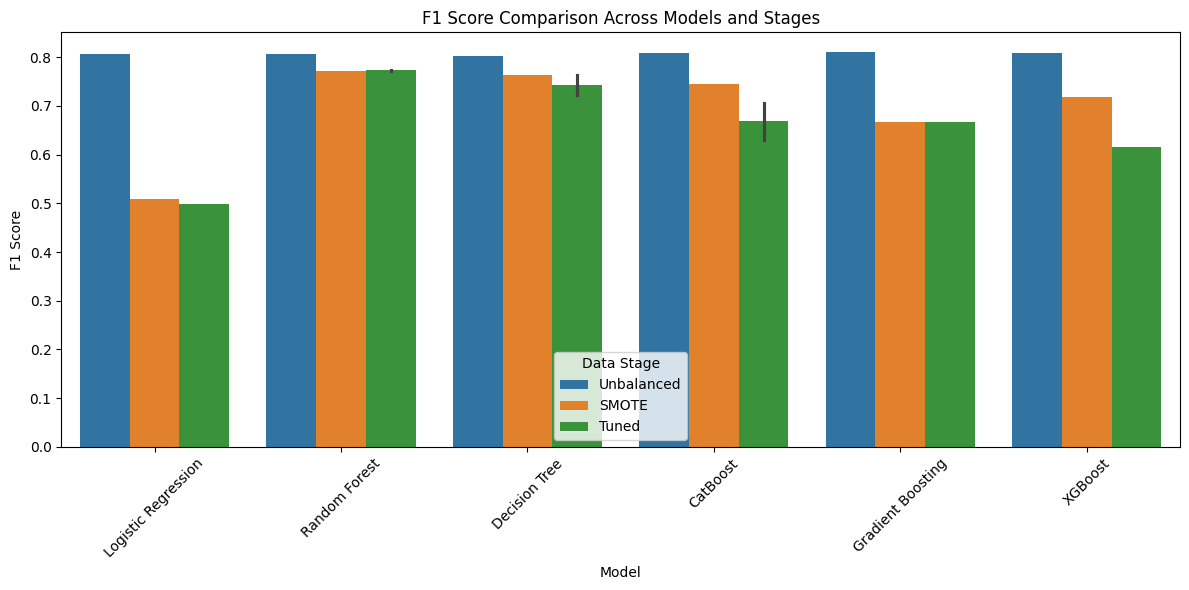

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(
    data=full_df,
    x="Model Name",
    y="F1 Score",
    hue="Stage"
)
plt.title("F1 Score Comparison Across Models and Stages")
plt.ylabel("F1 Score")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.legend(title="Data Stage")
plt.tight_layout()
plt.show()


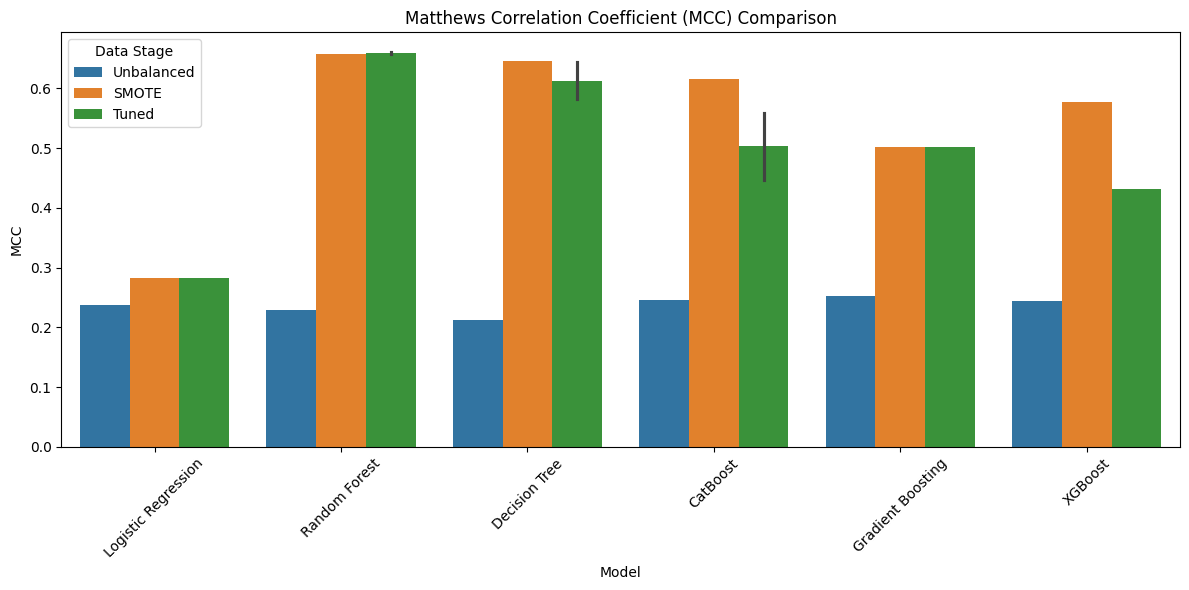

In [39]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=full_df,
    x="Model Name",
    y="MCC",
    hue="Stage"
)
plt.title("Matthews Correlation Coefficient (MCC) Comparison")
plt.ylabel("MCC")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.legend(title="Data Stage")
plt.tight_layout()
plt.show()


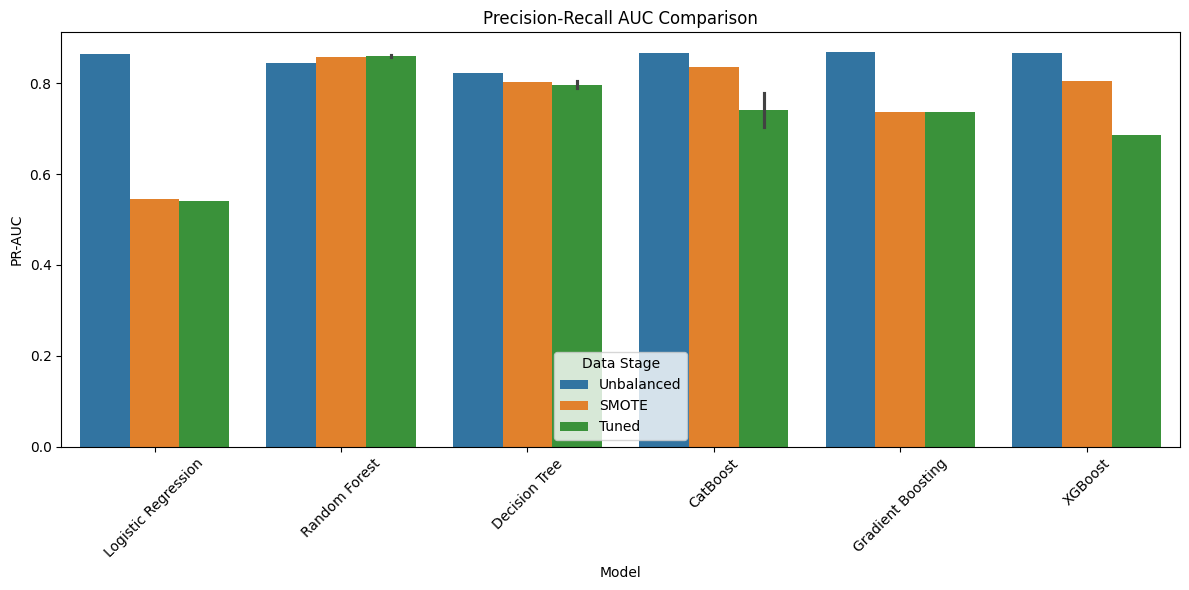

In [40]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=full_df,
    x="Model Name",
    y="PR-AUC",
    hue="Stage"
)
plt.title("Precision-Recall AUC Comparison")
plt.ylabel("PR-AUC")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.legend(title="Data Stage")
plt.tight_layout()
plt.show()


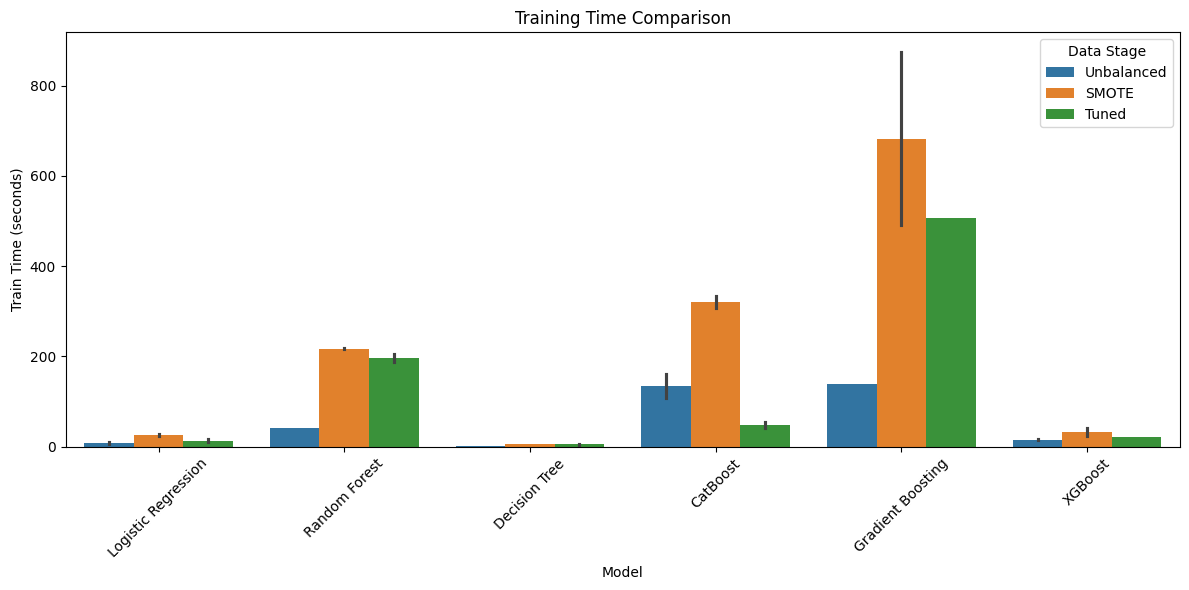

In [41]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=full_df,
    x="Model Name",
    y="Train Time (s)",
    hue="Stage"
)
plt.title("Training Time Comparison")
plt.ylabel("Train Time (seconds)")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.legend(title="Data Stage")
plt.tight_layout()
plt.show()
